# Creation of Samples

For a given couple of pipeline, we have 1000 group analyses. The function **voxel_concat** takes as input the parameter values for the first and the second pipeline, stores all the statistical values contained within the mask in a list for each of the 1000 group analyses, and returns a concatenation of the 1000 lists obtained.

Since the resulting list of voxels obtained is very large (more than 150M statistical values) and using it for further observations can be very time-consuming, for each between-group analysis using two given pipelines, on which we wanted to make observations, we only took a random sample of 1M values from the concatenation of statistical values over the 1000 corresponding group analyses. The function **save_sample** takes a vector and a file name as input and stores a random sample (fixed with a seed) within a .txt file.

To avoid having to execute *voxel_concat* (which can take a long time) each time we need to extract the sample values, and thus simplify the re-execution of the notebook, we will use a function **voxel_concat_sample**, which takes as input parameter values for both pipelines, uses *voxel_concat* and *save_sample* as auxiliary functions to create the random sample file only if it does not exists already, and reads and returns the file content when the file exists.

Functions **voxel_concat_fsl** and **voxel_concat_sample_fsl** were created to obtained the same results for analyses using FSL.

In [2]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from matplotlib import rc

# activate latex text rendering
rc('text', usetex=True)

In [3]:
import statsmodels.api as sm 
import pylab as py

In [4]:
import nibabel as nib
import random

In [5]:
def voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2):
    Vect_vox=[]
    smooth1=str(smooth1)
    smooth2=str(smooth2)
    reg1=str(reg1)
    reg2=str(reg2)
    der1=str(der1)
    der2=str(der2)
    for i in range(1000):
        fold='SLA'+str(i+1)+'_50_hand'
        V0 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'spmT_0001.nii.gz')).get_data().flatten()
        V1 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'mask.nii.gz')).get_data().flatten()
        V0bis=V0[V1!=0].tolist()
        Vect_vox=Vect_vox+V0bis
    return Vect_vox;

In [6]:
def save_sample(data,name):
    random.seed(0)
    data_sample=random.sample(data,1000000)
    
    sample_file = open(name+".txt","w")
    for i in range(1000000):
        sample_file.write(str(data_sample[i]))
        if i!=999999:
            sample_file.write(" \n")
    sample_file.close()

In [7]:
def voxel_concat_sample(smooth1,reg1,der1,smooth2,reg2,der2):
    
    if not(os.path.isfile('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt')):
        vect_vox1 = voxel_concat(smooth1,reg1,der1,smooth2,reg2,der2)
        save_sample(vect_vox1,'sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2))
        
    with open('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'.txt',"r") as V0:
        filecontents=V0.readlines()
    Vect_vox_sample=[float(i) for i in filecontents]
    return Vect_vox_sample;

In [8]:
def voxel_concat_fsl(smooth1,reg1,der1,smooth2,reg2,der2):
    Vect_vox=[]
    smooth1=str(smooth1)
    smooth2=str(smooth2)
    reg1=str(reg1)
    reg2=str(reg2)
    der1=str(der1)
    der2=str(der2)
    for i in range(1000):
        fold='SLA'+str(i+1)+'_50_hand_FSL'
        V0 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'spmT_0001.nii.gz')).get_data().flatten()
        V1 = nib.load(os.path.join('..', 'data',fold,'smooth_'+smooth1+'_'+smooth2,'reg_'+reg1+'_'+reg2,'der_'+der1+'_'+der2,'mask.nii.gz')).get_data().flatten()
        V0bis=V0[V1!=0].tolist()
        Vect_vox=Vect_vox+V0bis
    return Vect_vox;

In [9]:
def voxel_concat_sample_fsl(smooth1,reg1,der1,smooth2,reg2,der2):
    
    if not(os.path.isfile('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'_fsl.txt')):
        vect_vox1 = voxel_concat_fsl(smooth1,reg1,der1,smooth2,reg2,der2)
        save_sample(vect_vox1,'sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'_fsl')
        
    with open('sample_'+str(smooth1)+str(reg1)+str(der1)+'_'+str(smooth2)+str(reg2)+str(der2)+'_fsl.txt',"r") as V0:
        filecontents=V0.readlines()
    Vect_vox_sample=[float(i) for i in filecontents]
    return Vect_vox_sample;

## Pairs of Pipelines

We defined samples for between-group analyses using two given pipelines, for multiple pairs of pipelines, both in SPM and FSL.

In [11]:
Vect_vox_5240_5240_sample = voxel_concat_sample(5,24,0,5,24,0);

In [12]:
Vect_vox_5240_5241_sample = voxel_concat_sample(5,24,0,5,24,1);

In [13]:
Vect_vox_5240_800_sample = voxel_concat_sample(5,24,0,8,0,0);

In [14]:
Vect_vox_5240_860_sample = voxel_concat_sample(5,24,0,8,6,0);

In [15]:
Vect_vox_5240_8240_sample = voxel_concat_sample(5,24,0,8,24,0);

In [16]:
Vect_vox_800_800_sample = voxel_concat_sample(8,0,0,8,0,0);

In [17]:
Vect_vox_800_5240_sample = voxel_concat_sample(8,0,0,5,24,0);

In [18]:
Vect_vox_500_5240_sample = voxel_concat_sample(5,0,0,5,24,0);

In [19]:
Vect_vox_500_8240_sample = voxel_concat_sample(5,0,0,8,24,0);

In [20]:
Vect_vox_500_560_sample = voxel_concat_sample(5,0,0,5,6,0);

In [21]:
Vect_vox_560_560_sample = voxel_concat_sample(5,6,0,5,6,0);

In [22]:
Vect_vox_5241_5240_sample = voxel_concat_sample(5,24,1,5,24,0);

In [23]:
Vect_vox_5241_5241_sample = voxel_concat_sample(5,24,1,5,24,1);

In [24]:
Vect_vox_5240_8241_sample = voxel_concat_sample(5,24,0,8,24,1);

In [25]:
Vect_vox_5241_8240_sample = voxel_concat_sample(5,24,1,8,24,0);

In [26]:
Vect_vox_5241_8241_sample = voxel_concat_sample(5,24,1,8,24,1);

In [27]:
Vect_vox_5240_560_sample = voxel_concat_sample(5,24,0,5,6,0);

In [28]:
Vect_vox_5240_500_sample = voxel_concat_sample(5,24,0,5,0,0);

In [29]:
Vect_vox_5240_800_sample = voxel_concat_sample(5,24,0,8,0,0);

In [30]:
Vect_vox_8240_5240_sample = voxel_concat_sample(8,24,0,5,24,0);

In [31]:
Vect_vox_8240_8240_sample = voxel_concat_sample(8,24,0,8,24,0);

In [32]:
Vect_vox_560_5240_sample = voxel_concat_sample(5,6,0,5,24,0);

In [33]:
Vect_vox_560_500_sample = voxel_concat_sample(5,6,0,5,0,0);

In [34]:
Vect_vox_500_500_sample = voxel_concat_sample(5,0,0,5,0,0);

In [35]:
Vect_vox_8241_8241_sample = voxel_concat_sample(8,24,1,8,24,1);

In [36]:
Vect_vox_8241_5240_sample = voxel_concat_sample(8,24,1,5,24,0);

In [37]:
Vect_vox_5240_8241_sample = voxel_concat_sample(5,24,0,8,24,1);

In [38]:
Vect_vox_800_800_sample = voxel_concat_sample(8,0,0,8,0,0);

In [39]:
Vect_vox_5240_800_sample = voxel_concat_sample(5,24,0,8,0,0);

In [40]:
Vect_vox_800_5240_sample = voxel_concat_sample(8,0,0,5,24,0);

In [41]:
Vect_vox_5240_5240_fsl_sample = voxel_concat_sample_fsl(5,24,0,5,24,0);

In [42]:
Vect_vox_5240_5241_fsl_sample = voxel_concat_sample_fsl(5,24,0,5,24,1);

In [43]:
Vect_vox_5241_5240_fsl_sample = voxel_concat_sample_fsl(5,24,1,5,24,0);

In [44]:
Vect_vox_5241_5241_fsl_sample = voxel_concat_sample_fsl(5,24,1,5,24,1);

In [45]:
Vect_vox_5240_8240_fsl_sample = voxel_concat_sample_fsl(5,24,0,8,24,0);

In [46]:
Vect_vox_8240_5240_fsl_sample = voxel_concat_sample_fsl(8,24,0,5,24,0);

In [47]:
Vect_vox_8240_8240_fsl_sample = voxel_concat_sample_fsl(8,24,0,8,24,0);

In [48]:
Vect_vox_5240_560_fsl_sample = voxel_concat_sample_fsl(5,24,0,5,6,0);

In [49]:
Vect_vox_5240_500_fsl_sample = voxel_concat_sample_fsl(5,24,0,5,0,0);

In [50]:
Vect_vox_560_5240_fsl_sample = voxel_concat_sample_fsl(5,6,0,5,24,0);

In [51]:
Vect_vox_560_560_fsl_sample = voxel_concat_sample_fsl(5,6,0,5,6,0);

In [52]:
Vect_vox_560_500_fsl_sample = voxel_concat_sample_fsl(5,6,0,5,0,0);

In [53]:
Vect_vox_500_5240_fsl_sample = voxel_concat_sample_fsl(5,0,0,5,24,0);

In [54]:
Vect_vox_500_560_fsl_sample = voxel_concat_sample_fsl(5,0,0,5,6,0);

In [55]:
Vect_vox_500_500_fsl_sample = voxel_concat_sample_fsl(5,0,0,5,0,0);

In [56]:
Vect_vox_5240_8241_fsl_sample = voxel_concat_sample_fsl(5,24,0,8,24,1);

In [57]:
Vect_vox_5240_800_fsl_sample = voxel_concat_sample_fsl(5,24,0,8,0,0);

In [58]:
Vect_vox_800_800_fsl_sample = voxel_concat_sample_fsl(8,0,0,8,0,0);

In [59]:
Vect_vox_800_5240_fsl_sample = voxel_concat_sample_fsl(8,0,0,5,24,0);

In [60]:
Vect_vox_8241_8241_fsl_sample = voxel_concat_sample_fsl(8,24,1,8,24,1);

In [61]:
Vect_vox_8241_5240_fsl_sample = voxel_concat_sample_fsl(8,24,1,5,24,0);

# Observations on the Data

## Statistical Distributions

Distributions of the statistical values were observed for various between-group analyses, and compared to the the distribution associated to the Student law with $n=98$ degrees of freedom.

## Logarithmic P-P plots

For a given set of statistical values that is expected to follow a certain distribution, we can obtained the p-values associated to the statistical values $x_i$, which are to $1 - F(x_i)$ (where F is the distribution function).

Since the p-values are expected to follow a uniform distribution on $[0;1]$, for a set of $N$ statistical values, the $k^{th}$ ordered p-value is expected to be equal to $k/(N+1)$ (for our samples of 1000000 statistical values, $k/(1000001)$).

P-P plots are used to observe how a given set of statistical values diverge from an expected distribution by plotting, for each ordered statistical value, the expected associated p-value on the x-axis and the obtained p-value on the y-axis. Here we use variants fo P-P plots by replacing the p-values by the following:

-on the x-axis: $log_{10}$(expected p-value) instead of the expected p-value

-on the y-axis: $log_{10}$(obtained p-value) - $log_{10}$(expected p-value) instead of obtained p-value.

Doing so allows us to better observe what happens in the tail of our set of statistical values. Since we observe the $log_{10}$ values of the expected p-values, which go from $1/1000001$ to $1000000/1000001$, on the x-axis, the lowest and highest values on the x-axis are $-log_{10}(1000000/1000001) \approx 0$ and $-log_{10}(1/1000001) \approx 6$. For a given $k$, the $k$ lowest expected p-values on the x-axis are in the interval between $-log_{10}(k/1000001) \approx 6-log_{10}(k)$ and $-log_{10}(1/1000001) \approx 6$. Therefore, the logarithmic graph gives us a better observation of the behavior of the p-values around 0.

(Notably, since we plotted the confidence interval boundaries for the 10000 first p-values, it appears within the $[2,6]$ interval on the x-axis of the plot)

High statistical values (right tail of our sample) are associated to low p-values, i.e. to high $log_{10}$ of p-values. Statistical values in the tail are higher than expected when $log_{10}$(obtained p-value) - $log_{10}$(expected p-value) $> 0$, and lower when $log_{10}$(obtained p-value) - $log_{10}$(expected p-value) $< 0$.

# Results

## SPM

### P-P Plots

The P-P plots below are obtained for various between-group analyses with identical or different pipelines. Default parameter values for both pipelines are the following: 5mm for smoothing kernel FWHM value, 24 motion regressors and no temporal derivatives of the HRF in the GLM model). When not indicated, parameter values in both pipelines are equal to default values.

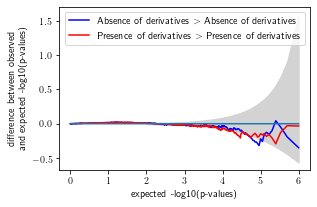

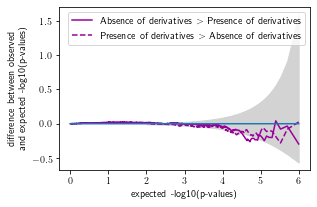

In [74]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_5241_5241_sample

data1_2=Vect_vox_5240_5241_sample
data2_2=Vect_vox_5241_5240_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["Absence of derivatives "+r"$>$"+" Absence of derivatives","Presence of derivatives "+r"$>$"+" Presence of derivatives"])   

plt.show()

f.savefig("QQplotder1.pdf", bbox_inches='tight')


f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["Absence of derivatives "+r"$>$"+" Presence of derivatives","Presence of derivatives "+r"$>$"+" Absence of derivatives"])   

plt.show()

f.savefig("QQplotder2.pdf", bbox_inches='tight')

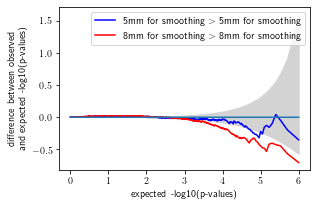

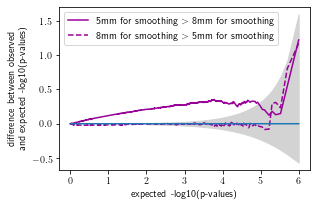

In [75]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_8240_8240_sample

data1_2=Vect_vox_5240_8240_sample
data2_2=Vect_vox_8240_5240_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing "+r"$>$"+" 5mm for smoothing","8mm for smoothing "+r"$>$"+" 8mm for smoothing"])   

plt.show()

f.savefig("QQplotsmooth1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing "+r"$>$"+" 8mm for smoothing","8mm for smoothing "+r"$>$"+" 5mm for smoothing"])   

plt.show()

f.savefig("QQplotsmooth2.pdf", bbox_inches='tight')

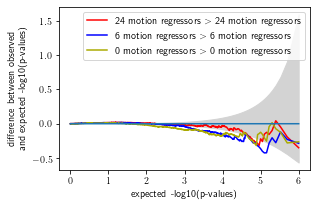

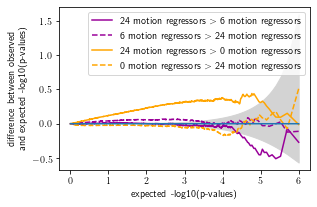

In [76]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_560_560_sample
data3_1=Vect_vox_500_500_sample

data1_2=Vect_vox_5240_560_sample
data2_2=Vect_vox_560_5240_sample
data3_2=Vect_vox_5240_500_sample
data4_2=Vect_vox_500_5240_sample


matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
p_obs_3_1 = -np.log10(sorted(dist.sf(np.array(data3_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]
ba_diff_3_1 = [(p_obs_3_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#FF0000')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#0000FF')
line3_1, = ax1.plot(p_th, ba_diff_3_1,'#AAAA00')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1,line3_1],["24 motion regressors "+r"$>$"+" 24 motion regressors","6 motion regressors "+r"$>$"+" 6 motion regressors","0 motion regressors "+r"$>$"+" 0 motion regressors"])   

plt.show()

f.savefig("QQplotreg1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
p_obs_3_2 = -np.log10(sorted(dist.sf(np.array(data3_2),98)))
p_obs_4_2 = -np.log10(sorted(dist.sf(np.array(data4_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]
ba_diff_3_2 = [(p_obs_3_2[i] - p_th[i]) for i in range(n)]
ba_diff_4_2 = [(p_obs_4_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle='dashed')
line3_2, = ax2.plot(p_th, ba_diff_3_2,'#FFA500')
line4_2, = ax2.plot(p_th, ba_diff_4_2,'#FFA500',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2,line3_2,line4_2],["24 motion regressors "+r"$>$"+" 6 motion regressors","6 motion regressors "+r"$>$"+" 24 motion regressors","24 motion regressors "+r"$>$"+" 0 motion regressors","0 motion regressors "+r"$>$"+" 24 motion regressors"])   

plt.show()

f.savefig("QQplotreg2.pdf", bbox_inches='tight')

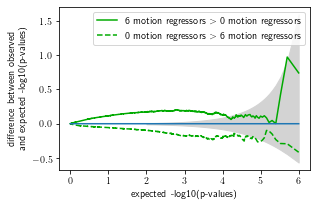

In [77]:
data1_2=Vect_vox_560_500_sample
data2_2=Vect_vox_500_560_sample


matplotlib.rc("text",usetex=True)
f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_2)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

ax1.axis('off')

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#00AA00')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#00AA00',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["6 motion regressors "+r"$>$"+" 0 motion regressors","0 motion regressors "+r"$>$"+" 6 motion regressors"])   

plt.show()

f.savefig("QQplotreg3.pdf", bbox_inches='tight')

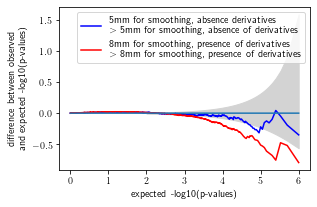

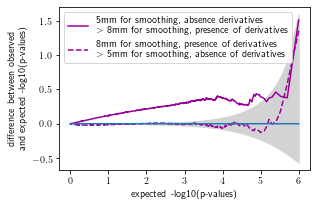

In [78]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_8241_8241_sample

data1_2=Vect_vox_5240_8241_sample
data2_2=Vect_vox_8241_5240_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing, absence derivatives\n "+r"$>$"+" 5mm for smoothing, absence of derivatives","8mm for smoothing, presence of derivatives\n "+r"$>$"+" 8mm for smoothing, presence of derivatives"])   

plt.show()

f.savefig("QQplotsmoothder1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle="dashed")
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing, absence derivatives\n "+r"$>$"+" 8mm for smoothing, presence of derivatives","8mm for smoothing, presence of derivatives\n "+r"$>$"+" 5mm for smoothing, absence of derivatives"])   

plt.show()

f.savefig("QQplotsmoothder2.pdf", bbox_inches='tight')

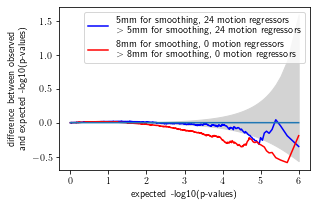

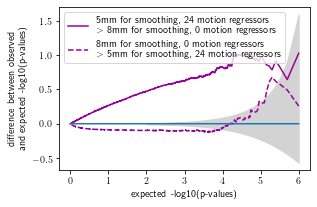

In [79]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_800_800_sample

data1_2=Vect_vox_5240_800_sample
data2_2=Vect_vox_800_5240_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing, 24 motion regressors\n "+r"$>$"+" 5mm for smoothing, 24 motion regressors","8mm for smoothing, 0 motion regressors\n "+r"$>$"+" 8mm for smoothing, 0 motion regressors"])   


plt.show()

f.savefig("QQplotsmoothreg1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle="dashed")
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing, 24 motion regressors\n "+r"$>$"+" 8mm for smoothing, 0 motion regressors","8mm for smoothing, 0 motion regressors\n "+r"$>$"+" 5mm for smoothing, 24 motion regressors"])   

plt.show()

f.savefig("QQplotsmoothreg2.pdf", bbox_inches='tight')

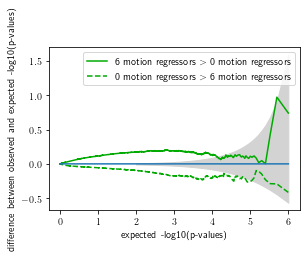

In [66]:
data1_2=Vect_vox_560_500_sample
data2_2=Vect_vox_500_560_sample


matplotlib.rc("text",usetex=True)
f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_2)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

ax1.axis('off')

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#00AA00')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#00AA00',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed and expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["6 motion regressors "+r"$>$"+" 0 motion regressors","0 motion regressors "+r"$>$"+" 6 motion regressors"])   

plt.show()

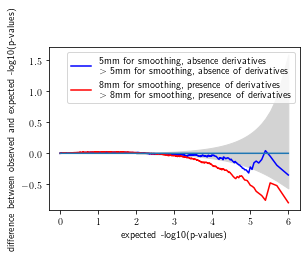

/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


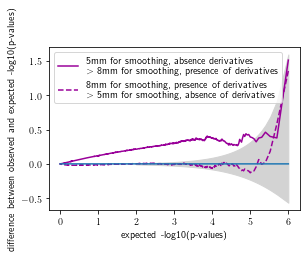

In [67]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_8241_8241_sample

data1_2=Vect_vox_5240_8241_sample
data2_2=Vect_vox_8241_5240_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed and expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing, absence derivatives\n "+r"$>$"+" 5mm for smoothing, absence of derivatives","8mm for smoothing, presence of derivatives\n "+r"$>$"+" 8mm for smoothing, presence of derivatives"])   

plt.show()
f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle="dashed")
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed and expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing, absence derivatives\n "+r"$>$"+" 8mm for smoothing, presence of derivatives","8mm for smoothing, presence of derivatives\n "+r"$>$"+" 5mm for smoothing, absence of derivatives"])   

plt.show()

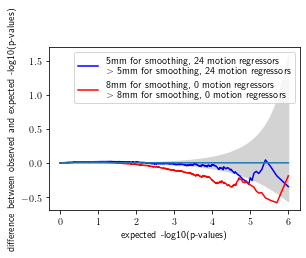

/usr/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


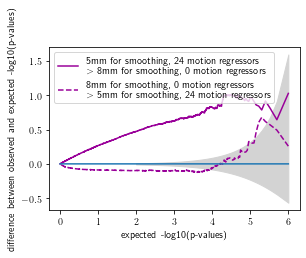

In [68]:
data1_1=Vect_vox_5240_5240_sample
data2_1=Vect_vox_800_800_sample

data1_2=Vect_vox_5240_800_sample
data2_2=Vect_vox_800_5240_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed and expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing, 24 motion regressors\n "+r"$>$"+" 5mm for smoothing, 24 motion regressors","8mm for smoothing, 0 motion regressors\n "+r"$>$"+" 8mm for smoothing, 0 motion regressors"])   


plt.show()
f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle="dashed")
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed and expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing, 24 motion regressors\n "+r"$>$"+" 8mm for smoothing, 0 motion regressors","8mm for smoothing, 0 motion regressors\n "+r"$>$"+" 5mm for smoothing, 24 motion regressors"])   

plt.show()

### Distributions

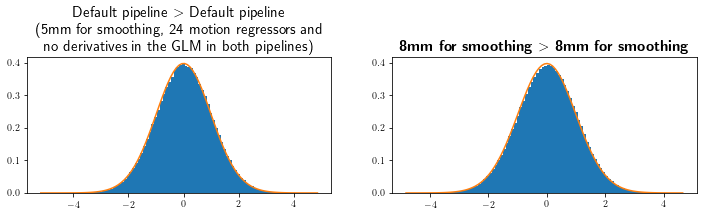

In [86]:
data1=Vect_vox_5240_5240_sample
data2=Vect_vox_8240_8240_sample
f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)

n1, bins1, patches1 = ax1.hist(np.array(data1),100,density=True)
y1=dist.pdf(bins1,98)
ax1.plot(bins1, y1, '-')
ax1.set_title("Default pipeline "+r"$>$"+" Default pipeline \n(5mm for smoothing, 24 motion regressors and \nno derivatives in the GLM in both pipelines)",fontsize=15)
n2, bins2, patches2 = ax2.hist(np.array(data2),100,density=True)
y2=dist.pdf(bins2,98)
ax2.plot(bins2, y2, '-')
ax2.set_title(r"$\textbf{8mm for smoothing}$ $>$ $\textbf{8mm for smoothing}$",fontsize=15)
plt.show()

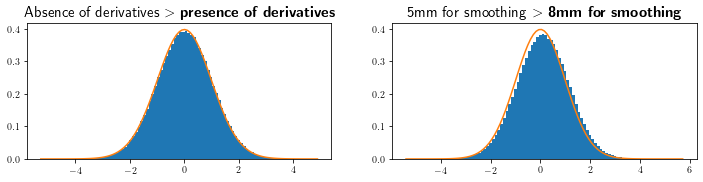

In [87]:
data3=Vect_vox_5240_5241_sample
data4=Vect_vox_5240_8240_sample
f,(ax3,ax4) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)


n3, bins3, patches3 = ax3.hist(np.array(data3),100,density=True)
y3=dist.pdf(bins3,98)
ax3.plot(bins3, y3, '-')
ax3.set_title("Absence of derivatives "+r"$>$"+r" $\textbf{presence of derivatives}$",fontsize=15)
n4, bins4, patches4 = ax4.hist(np.array(data4),100,density=True)
y4=dist.pdf(bins4,98)
ax4.plot(bins4, y4, '-')
ax4.set_title("5mm for smoothing "+r"$>$"+r" $\textbf{8mm for smoothing}$",fontsize=15)
plt.show()

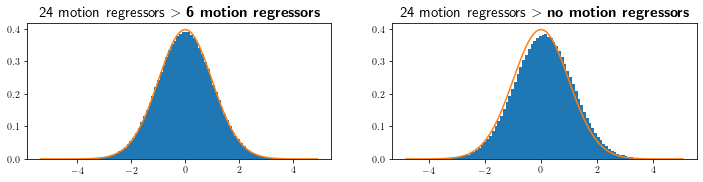

In [88]:
data5=Vect_vox_5240_560_sample
data6=Vect_vox_5240_500_sample
f,(ax5,ax6) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)

n5, bins5, patches5 = ax5.hist(np.array(data5),100,density=True)
y5=dist.pdf(bins5,98)
ax5.plot(bins5, y5, '-')
ax5.set_title("24 motion regressors "+r"$>$"+r" $\textbf{6 motion regressors}$",fontsize=15)
n6, bins6, patches6 = ax6.hist(np.array(data6),100,density=True)
y6=dist.pdf(bins6,98)
ax6.plot(bins6, y6, '-')
ax6.set_title("24 motion regressors "+r"$>$"+r" $\textbf{no motion regressors}$",fontsize=15)
plt.show()

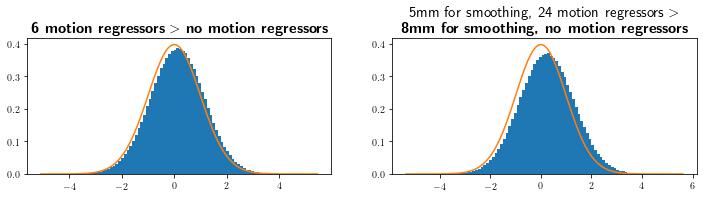

In [89]:
data7=Vect_vox_560_500_sample
data8=Vect_vox_5240_800_sample
f,(ax7,ax8) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)

n7, bins7, patches7 = ax7.hist(np.array(data7),100,density=True)
y7=dist.pdf(bins7,98)
ax7.plot(bins7, y7, '-')
ax7.set_title(r"$\textbf{6 motion regressors} $"+r" $>$ "+r"$ \textbf{no motion regressors}$",fontsize=15)
n8, bins8, patches8 = ax8.hist(np.array(data8),100,density=True)
y8=dist.pdf(bins8,98)
ax8.plot(bins8, y8, '-')
ax8.set_title("5mm for smoothing, 24 motion regressors "+r"$>$ "+"\n"+r" $\textbf{8mm for smoothing, no motion regressors}$",fontsize=15)

plt.show()

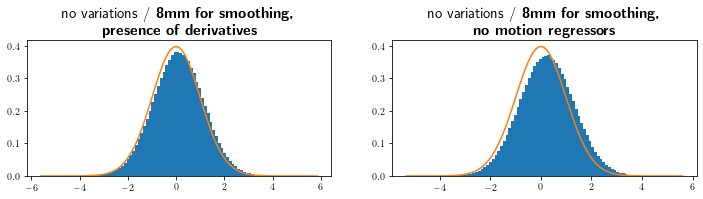

In [196]:
data9=Vect_vox_5240_8241_sample
data10=Vect_vox_5240_800_sample
f,(ax9,ax10) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)


n9, bins9, patches9 = ax9.hist(np.array(data9),100,density=True)
y9=dist.pdf(bins9,98)
ax9.plot(bins9, y9, '-')
ax9.set_title("no variations / "+r"$\textbf{8mm for smoothing,}$"+"\n"+r"$\textbf{presence of derivatives}$",fontsize=15)
n10, bins10, patches10 = ax10.hist(np.array(data10),100,density=True)
y10=dist.pdf(bins10,98)
ax10.plot(bins10, y10, '-')
ax10.set_title("no variations / "+r"$\textbf{8mm for smoothing,}$"+"\n"+r"$\textbf{no motion regressors}$",fontsize=15)
plt.show()

## FSL

### P-P Plots

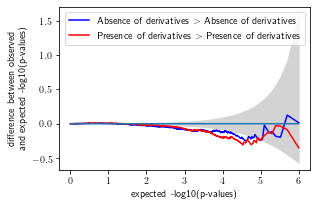

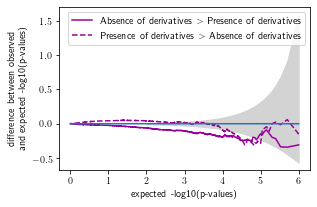

In [68]:
data1_1=Vect_vox_5240_5240_fsl_sample
data2_1=Vect_vox_5241_5241_fsl_sample

data1_2=Vect_vox_5240_5241_fsl_sample
data2_2=Vect_vox_5241_5240_fsl_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["Absence of derivatives "+r"$>$"+" Absence of derivatives","Presence of derivatives "+r"$>$"+" Presence of derivatives"])   

plt.show()

f.savefig("QQplotfslder1.pdf", bbox_inches='tight')


f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["Absence of derivatives "+r"$>$"+" Presence of derivatives","Presence of derivatives "+r"$>$"+" Absence of derivatives"])   

plt.show()

f.savefig("QQplotfslder2.pdf", bbox_inches='tight')

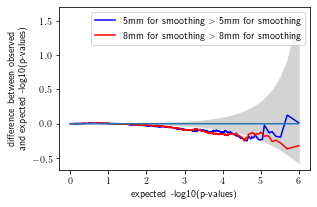

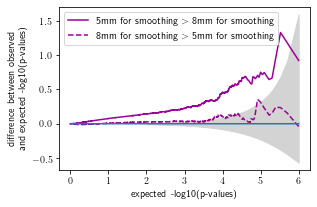

In [69]:
data1_1=Vect_vox_5240_5240_fsl_sample
data2_1=Vect_vox_8240_8240_fsl_sample

data1_2=Vect_vox_5240_8240_fsl_sample
data2_2=Vect_vox_8240_5240_fsl_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing "+r"$>$"+" 5mm for smoothing","8mm for smoothing "+r"$>$"+" 8mm for smoothing"])   

plt.show()

f.savefig("QQplotfslsmooth1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing "+r"$>$"+" 8mm for smoothing","8mm for smoothing "+r"$>$"+" 5mm for smoothing"])   

plt.show()

f.savefig("QQplotfslsmooth2.pdf", bbox_inches='tight')

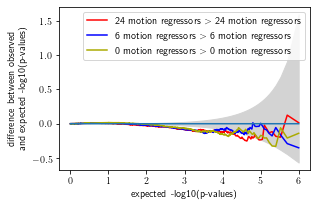

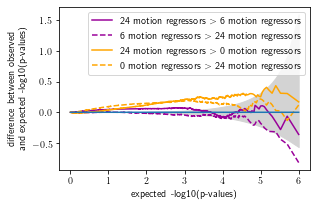

In [70]:
data1_1=Vect_vox_5240_5240_fsl_sample
data2_1=Vect_vox_560_560_fsl_sample
data3_1=Vect_vox_500_500_fsl_sample

data1_2=Vect_vox_5240_560_fsl_sample
data2_2=Vect_vox_560_5240_fsl_sample
data3_2=Vect_vox_5240_500_fsl_sample
data4_2=Vect_vox_500_5240_fsl_sample


matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
p_obs_3_1 = -np.log10(sorted(dist.sf(np.array(data3_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]
ba_diff_3_1 = [(p_obs_3_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#FF0000')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#0000FF')
line3_1, = ax1.plot(p_th, ba_diff_3_1,'#AAAA00')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1,line3_1],["24 motion regressors "+r"$>$"+" 24 motion regressors","6 motion regressors "+r"$>$"+" 6 motion regressors","0 motion regressors "+r"$>$"+" 0 motion regressors"])   

plt.show()

f.savefig("QQplotfslreg1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
p_obs_3_2 = -np.log10(sorted(dist.sf(np.array(data3_2),98)))
p_obs_4_2 = -np.log10(sorted(dist.sf(np.array(data4_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]
ba_diff_3_2 = [(p_obs_3_2[i] - p_th[i]) for i in range(n)]
ba_diff_4_2 = [(p_obs_4_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle='dashed')
line3_2, = ax2.plot(p_th, ba_diff_3_2,'#FFA500')
line4_2, = ax2.plot(p_th, ba_diff_4_2,'#FFA500',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2,line3_2,line4_2],["24 motion regressors "+r"$>$"+" 6 motion regressors","6 motion regressors "+r"$>$"+" 24 motion regressors","24 motion regressors "+r"$>$"+" 0 motion regressors","0 motion regressors "+r"$>$"+" 24 motion regressors"])   

plt.show()

f.savefig("QQplotfslreg2.pdf", bbox_inches='tight')

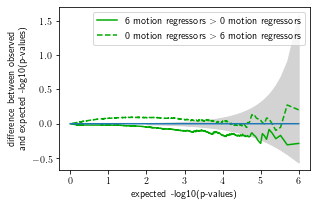

In [71]:
data1_2=Vect_vox_560_500_fsl_sample
data2_2=Vect_vox_500_560_fsl_sample


matplotlib.rc("text",usetex=True)
f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_2)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

ax1.axis('off')

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#00AA00')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#00AA00',linestyle='dashed')
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["6 motion regressors "+r"$>$"+" 0 motion regressors","0 motion regressors "+r"$>$"+" 6 motion regressors"])   

plt.show()

f.savefig("QQplotfslreg3.pdf", bbox_inches='tight')

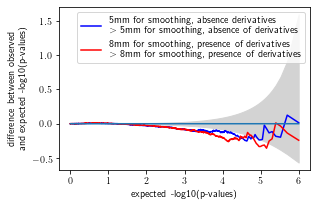

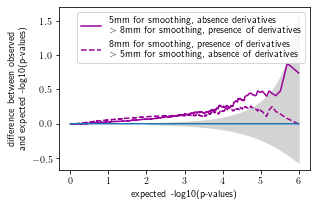

In [72]:
data1_1=Vect_vox_5240_5240_fsl_sample
data2_1=Vect_vox_8241_8241_fsl_sample

data1_2=Vect_vox_5240_8241_fsl_sample
data2_2=Vect_vox_8241_5240_fsl_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing, absence derivatives\n "+r"$>$"+" 5mm for smoothing, absence of derivatives","8mm for smoothing, presence of derivatives\n "+r"$>$"+" 8mm for smoothing, presence of derivatives"])   

plt.show()

f.savefig("QQplotfslsmoothder1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle="dashed")
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing, absence derivatives\n "+r"$>$"+" 8mm for smoothing, presence of derivatives","8mm for smoothing, presence of derivatives\n "+r"$>$"+" 5mm for smoothing, absence of derivatives"])   

plt.show()

f.savefig("QQplotfslsmoothder2.pdf", bbox_inches='tight')

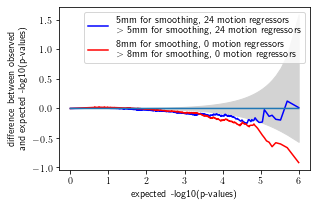

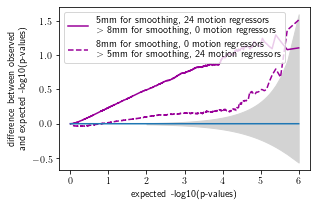

In [73]:
data1_1=Vect_vox_5240_5240_fsl_sample
data2_1=Vect_vox_800_800_fsl_sample

data1_2=Vect_vox_5240_800_fsl_sample
data2_2=Vect_vox_800_5240_fsl_sample

matplotlib.rc("text",usetex=True)
f,(ax1) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))

n=len(data1_1)

dist = scipy.stats.t
beta = scipy.stats.beta
p_th = -np.log10([t/(n+1) for t in range(1,n+1)])
p_th_sub=-np.log10([t/(n+1) for t in range(1,10001)])    
    
conf_int_inf_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[0])+np.log10(i/(n+1)) for i in range(1,10001)]
conf_int_sup_1 = [-np.log10(beta.interval(0.95,i,n-i+1,loc=0,scale=1)[1])+np.log10(i/(n+1)) for i in range(1,10001)]     

p_obs_1_1 = -np.log10(sorted(dist.sf(np.array(data1_1),98)))
p_obs_2_1 = -np.log10(sorted(dist.sf(np.array(data2_1),98)))
    
ba_diff_1_1 = [(p_obs_1_1[i] - p_th[i]) for i in range(n)]
ba_diff_2_1 = [(p_obs_2_1[i] - p_th[i]) for i in range(n)]

line1_1, = ax1.plot(p_th, ba_diff_1_1,'#0000FF')
line2_1, = ax1.plot(p_th, ba_diff_2_1,'#FF0000')
    
ax1.plot(p_th,n*[0],'-')
ax1.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax1.set_xlabel('expected -log10(p-values)')
ax1.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax1.legend([line1_1,line2_1],["5mm for smoothing, 24 motion regressors\n "+r"$>$"+" 5mm for smoothing, 24 motion regressors","8mm for smoothing, 0 motion regressors\n "+r"$>$"+" 8mm for smoothing, 0 motion regressors"])   


plt.show()

f.savefig("QQplotfslsmoothreg1.pdf", bbox_inches='tight')

f,(ax2) = plt.subplots(1,1,sharey=False,figsize=(4.5,3))


p_obs_1_2 = -np.log10(sorted(dist.sf(np.array(data1_2),98)))
p_obs_2_2 = -np.log10(sorted(dist.sf(np.array(data2_2),98)))
    
ba_diff_1_2 = [(p_obs_1_2[i] - p_th[i]) for i in range(n)]
ba_diff_2_2 = [(p_obs_2_2[i] - p_th[i]) for i in range(n)]

line1_2, = ax2.plot(p_th, ba_diff_1_2,'#990099')
line2_2, = ax2.plot(p_th, ba_diff_2_2,'#990099',linestyle="dashed")
    
ax2.plot(p_th,n*[0],'-')
ax2.fill_between(p_th_sub,conf_int_inf_1,conf_int_sup_1,color="lightgrey")
    
ax2.set_xlabel('expected -log10(p-values)')
ax2.set_ylabel('difference between observed\nand expected -log10(p-values)')
ax2.legend([line1_2,line2_2],["5mm for smoothing, 24 motion regressors\n "+r"$>$"+" 8mm for smoothing, 0 motion regressors","8mm for smoothing, 0 motion regressors\n "+r"$>$"+" 5mm for smoothing, 24 motion regressors"])   

plt.show()

f.savefig("QQplotfslsmoothreg2.pdf", bbox_inches='tight')

### Distributions

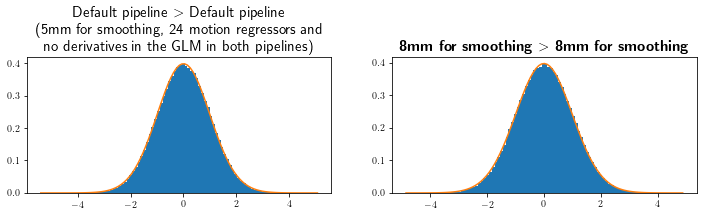

In [82]:
data1=Vect_vox_5240_5240_fsl_sample
data2=Vect_vox_8240_8240_fsl_sample
f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)

n1, bins1, patches1 = ax1.hist(np.array(data1),100,density=True)
y1=dist.pdf(bins1,98)
ax1.plot(bins1, y1, '-')
ax1.set_title("Default pipeline "+r"$>$"+" Default pipeline \n(5mm for smoothing, 24 motion regressors and \nno derivatives in the GLM in both pipelines)",fontsize=15)
n2, bins2, patches2 = ax2.hist(np.array(data2),100,density=True)
y2=dist.pdf(bins2,98)
ax2.plot(bins2, y2, '-')
ax2.set_title(r"$\textbf{8mm for smoothing}$ $>$ $\textbf{8mm for smoothing}$",fontsize=15)
plt.show()

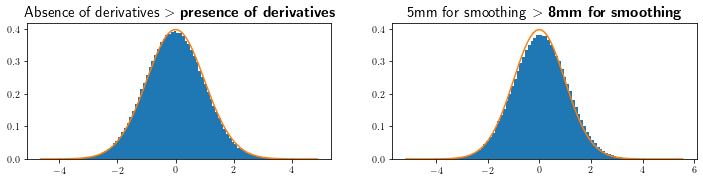

In [85]:
data3=Vect_vox_5240_5241_fsl_sample
data4=Vect_vox_5240_8240_fsl_sample
f,(ax3,ax4) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)


n3, bins3, patches3 = ax3.hist(np.array(data3),100,density=True)
y3=dist.pdf(bins3,98)
ax3.plot(bins3, y3, '-')
ax3.set_title("Absence of derivatives "+r"$>$"+r" $\textbf{presence of derivatives}$",fontsize=15)
n4, bins4, patches4 = ax4.hist(np.array(data4),100,density=True)
y4=dist.pdf(bins4,98)
ax4.plot(bins4, y4, '-')
ax4.set_title("5mm for smoothing "+r"$>$"+r" $\textbf{8mm for smoothing}$",fontsize=15)
plt.show()

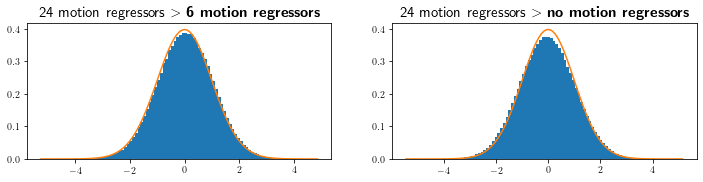

In [84]:
data5=Vect_vox_5240_560_fsl_sample
data6=Vect_vox_5240_500_fsl_sample
f,(ax5,ax6) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)

n5, bins5, patches5 = ax5.hist(np.array(data5),100,density=True)
y5=dist.pdf(bins5,98)
ax5.plot(bins5, y5, '-')
ax5.set_title("24 motion regressors "+r"$>$"+r" $\textbf{6 motion regressors}$",fontsize=15)
n6, bins6, patches6 = ax6.hist(np.array(data6),100,density=True)
y6=dist.pdf(bins6,98)
ax6.plot(bins6, y6, '-')
ax6.set_title("24 motion regressors "+r"$>$"+r" $\textbf{no motion regressors}$",fontsize=15)
plt.show()

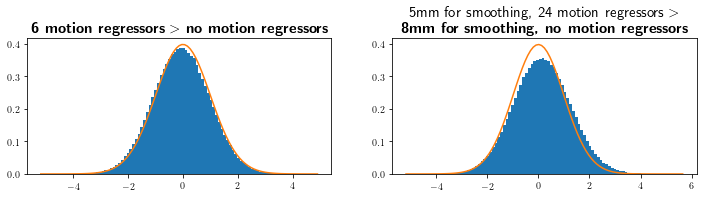

In [83]:
data7=Vect_vox_560_500_fsl_sample
data8=Vect_vox_5240_800_fsl_sample
f,(ax7,ax8) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)

n7, bins7, patches7 = ax7.hist(np.array(data7),100,density=True)
y7=dist.pdf(bins7,98)
ax7.plot(bins7, y7, '-')
ax7.set_title(r"$\textbf{6 motion regressors} $"+r" $>$ "+r"$ \textbf{no motion regressors}$",fontsize=15)
n8, bins8, patches8 = ax8.hist(np.array(data8),100,density=True)
y8=dist.pdf(bins8,98)
ax8.plot(bins8, y8, '-')
ax8.set_title("5mm for smoothing, 24 motion regressors "+r"$>$ "+"\n"+r" $\textbf{8mm for smoothing, no motion regressors}$",fontsize=15)

plt.show()

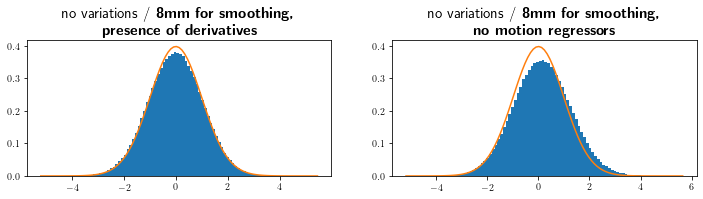

In [81]:
data9=Vect_vox_5240_8241_fsl_sample
data10=Vect_vox_5240_800_fsl_sample
f,(ax9,ax10) = plt.subplots(1,2,sharey=False,figsize=(12,2.5))

dist = scipy.stats.t
matplotlib.rc("text",usetex=True)


n9, bins9, patches9 = ax9.hist(np.array(data9),100,density=True)
y9=dist.pdf(bins9,98)
ax9.plot(bins9, y9, '-')
ax9.set_title("no variations / "+r"$\textbf{8mm for smoothing,}$"+"\n"+r"$\textbf{presence of derivatives}$",fontsize=15)
n10, bins10, patches10 = ax10.hist(np.array(data10),100,density=True)
y10=dist.pdf(bins10,98)
ax10.plot(bins10, y10, '-')
ax10.set_title("no variations / "+r"$\textbf{8mm for smoothing,}$"+"\n"+r"$\textbf{no motion regressors}$",fontsize=15)
plt.show()